In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41051")
client

<Client: 'tcp://127.0.0.1:41051' processes=8 threads=32, memory=125.87 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import interp2d, bisplrep, bisplev, griddata
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import MITgcmutils as mitutils
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]

In [6]:
reg = 0
ng = 3

ds = open_mdsdataset(op.join(ddir,'memb100/run1967/ocn'), 
                     grid_dir=gdir,
                     prefix=['snap_diagOcn'], delta_t=2e2,
                     iters=1419120, 
                    )
ds

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 900, XG: 1000, YG: 900, Z: 46, Zp1: 47,
              Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 1419120
  * time     (time) timedelta64[ns] 3285 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -19.92 -19.83 -19.75 -19.67 ... 54.75 54.83 54.92 55.0
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -19.96 -19.87 -19.79 -19.71 ... 54.71 54.79 54.88 54.96
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 900, 1000), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(900, 1000), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 900, 1000), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [7]:
dsg = open_mdsdataset(op.join(ddir,'memb100/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['diagUm'], delta_t=2e2,
                      iters=1419120, ignore_unknown_vars=True
                     ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                           YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                           XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                           XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                          )
dsg

<xarray.Dataset>
Dimensions:   (time: 1, XC: 122, YC: 126, XG: 122, YG: 126, Z: 46, Zp1: 47,
               Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter      (time) int64 1419120
  * time      (time) timedelta64[ns] 3285 days
  * XC        (XC) >f4 289.8 289.9 290.0 290.1 290.1 ... 300.0 300.0 300.1 300.2
  * YC        (YC) >f4 31.75 31.83 31.92 32.0 32.08 ... 41.92 42.0 42.08 42.17
  * XG        (XG) >f4 289.8 289.8 289.9 290.0 290.1 ... 299.9 300.0 300.1 300.2
  * YG        (YG) >f4 31.79 31.88 31.96 32.04 32.13 ... 41.96 42.04 42.13 42.21
    ...        ...
    maskW     (Z, YC, XG) bool dask.array<chunksize=(46, 126, 122), meta=np.ndarray>
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 126, 122), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(126, 122), meta=np.ndarray>
    rhoRef    (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW   (YC, XG) bool dask.array<chunksize=(126, 122), meta=np.ndarray>
    maskInS   (YG, XC) bool dask.array<chunksize=(126, 122), meta=np.ndarray>
Data variables:
    TOTUTEND  (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Um_Advec  (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Um_dPHdx  (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Um_Diss   (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Um_Ext    (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    AB_gU     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Um_Cori   (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [8]:
dsgv = open_mdsdataset(op.join(ddir,'memb100/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['diagVm'], delta_t=2e2,
                      iters=1419120, ignore_unknown_vars=True
                     ).sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                           YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                           XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
                           XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                          )
dsgv

<xarray.Dataset>
Dimensions:   (time: 1, XC: 122, YC: 126, XG: 122, YG: 126, Z: 46, Zp1: 47,
               Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter      (time) int64 1419120
  * time      (time) timedelta64[ns] 3285 days
  * XC        (XC) >f4 289.8 289.9 290.0 290.1 290.1 ... 300.0 300.0 300.1 300.2
  * YC        (YC) >f4 31.75 31.83 31.92 32.0 32.08 ... 41.92 42.0 42.08 42.17
  * XG        (XG) >f4 289.8 289.8 289.9 290.0 290.1 ... 299.9 300.0 300.1 300.2
  * YG        (YG) >f4 31.79 31.88 31.96 32.04 32.13 ... 41.96 42.04 42.13 42.21
    ...        ...
    maskW     (Z, YC, XG) bool dask.array<chunksize=(46, 126, 122), meta=np.ndarray>
    maskS     (Z, YG, XC) bool dask.array<chunksize=(46, 126, 122), meta=np.ndarray>
    maskInC   (YC, XC) bool dask.array<chunksize=(126, 122), meta=np.ndarray>
    rhoRef    (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW   (YC, XG) bool dask.array<chunksize=(126, 122), meta=np.ndarray>
    maskInS   (YG, XC) bool dask.array<chunksize=(126, 122), meta=np.ndarray>
Data variables:
    TOTVTEND  (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Vm_Advec  (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Vm_dPHdy  (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Vm_Diss   (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Vm_Ext    (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    AB_gV     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
    Vm_Cori   (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 126, 122), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [9]:
dsreg = ds.sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
               YG=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
               XC=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12),
               XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
              )

In [10]:
grid = Grid(dsreg, periodic=[])
xA = (dsreg.dyG * dsreg.drF).reset_coords(drop=True)
yA = (dsreg.dxG * dsreg.drF).reset_coords(drop=True)

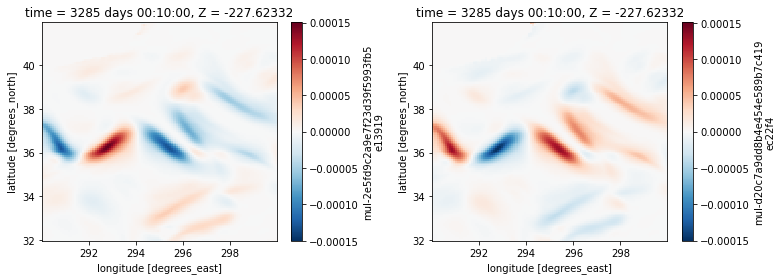

In [16]:
fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
(grid.interp(dsreg.UVEL * dsg.Um_Cori,'X',boundary='extend')
).isel(Z=14,YC=slice(ng,-ng),XC=slice(ng,-ng)).plot(ax=ax1)   
(grid.interp(dsreg.VVEL * dsgv.Vm_Cori,'Y',boundary='extend')
).isel(Z=14,YC=slice(ng,-ng),XC=slice(ng,-ng)).plot(ax=ax2)

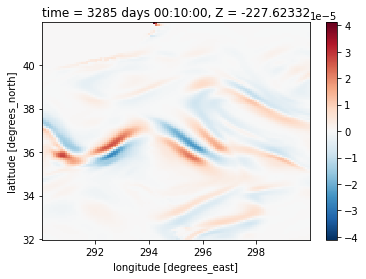

In [19]:
((grid.interp(dsreg.UVEL * dsg.Um_Cori,'X',boundary='extend')
 ).isel(Z=14,YC=slice(ng,-ng),XC=slice(ng,-ng)) 
 + (grid.interp(dsreg.VVEL * dsgv.Vm_Cori,'Y',boundary='extend')
   ).isel(Z=14,YC=slice(ng,-ng),XC=slice(ng,-ng))
).plot()

In [11]:
Um_dEdx_raw = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb100/run1967/ocn/diagUm'), 
                                          itrs=1419120, rec=3,    # U from surface pressure
                         # usememmap=True
                                     ),
                          dims=ds.UVEL.isel(time=0).dims, coords=ds.UVEL.isel(time=0).coords
                         )   
Um_Disv_raw = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb100/run1967/ocn/diagUm'), 
                                          itrs=1419120, rec=5,    # Vertical dissipation
                         # usememmap=True
                                     ),
                          dims=ds.UVEL.isel(time=0).dims, coords=ds.UVEL.isel(time=0).coords
                         )   
# print(Um_dEdx)
Um_dEdx = Um_dEdx_raw.sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                          XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                         )
Um_Disv = Um_Disv_raw.sel(YC=slice(ys[reg]-5-ng/12,ys[reg]+5+ng/12),
                          XG=slice(xs[reg]-5-ng/12,xs[reg]+5+ng/12)
                         )
Um_dEdx

<xarray.DataArray (Z: 46, YC: 126, XG: 122)>
array([[[ 3.45865033e-06,  2.89140144e-06,  2.59319086e-06, ...,
          8.14428040e-06,  6.78371907e-06,  5.45822286e-06],
        [ 1.59023193e-06,  1.00366469e-06,  7.45430839e-07, ...,
          8.39642144e-06,  7.21535980e-06,  5.99283794e-06],
        [-5.52392578e-07, -1.15104092e-06, -1.33838171e-06, ...,
          7.90841386e-06,  7.03060277e-06,  6.06749745e-06],
        ...,
        [-2.79523720e-05, -4.03765443e-05,  0.00000000e+00, ...,
         -8.66057599e-06, -9.84768394e-06, -1.10351375e-05],
        [-5.63624235e-06, -1.74761371e-05, -1.71477939e-06, ...,
         -4.84729617e-06, -5.27084467e-06, -5.86314809e-06],
        [ 1.89448701e-06, -6.74227385e-06, -1.66509608e-06, ...,
         -4.82317773e-06, -4.79031496e-06, -4.95790209e-06]],

       [[ 3.45865033e-06,  2.89140144e-06,  2.59319086e-06, ...,
          8.14428040e-06,  6.78371907e-06,  5.45822286e-06],
        [ 1.59023193e-06,  1.00366469e-06,  7.45430839e-07, ...,
          8.39642144e-06,  7.21535980e-06,  5.99283794e-06],
        [-5.52392578e-07, -1.15104092e-06, -1.33838171e-06, ...,
          7.90841386e-06,  7.03060277e-06,  6.06749745e-06],
...
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]])
Coordinates: (12/14)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * YC       (YC) >f4 31.75 31.83 31.92 32.0 32.08 ... 41.92 42.0 42.08 42.17
  * XG       (XG) >f4 289.8 289.8 289.9 290.0 290.1 ... 299.9 300.0 300.1 300.2
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    dyG      (YC, XG) >f4 dask.array<chunksize=(126, 122), meta=np.ndarray>
    ...       ...
    drF      (Z) >f4 6.094 6.721 7.099 7.971 8.65 ... 248.9 249.6 249.9 250.5
    PHrefC   (Z) >f4 29.89 92.74 160.5 234.4 ... 5.273e+04 5.518e+04 5.764e+04
    hFacW    (Z, YC, XG) >f4 dask.array<chunksize=(46, 126, 122), meta=np.ndarray>
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 126, 122), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(126, 122), meta=np.ndarray>

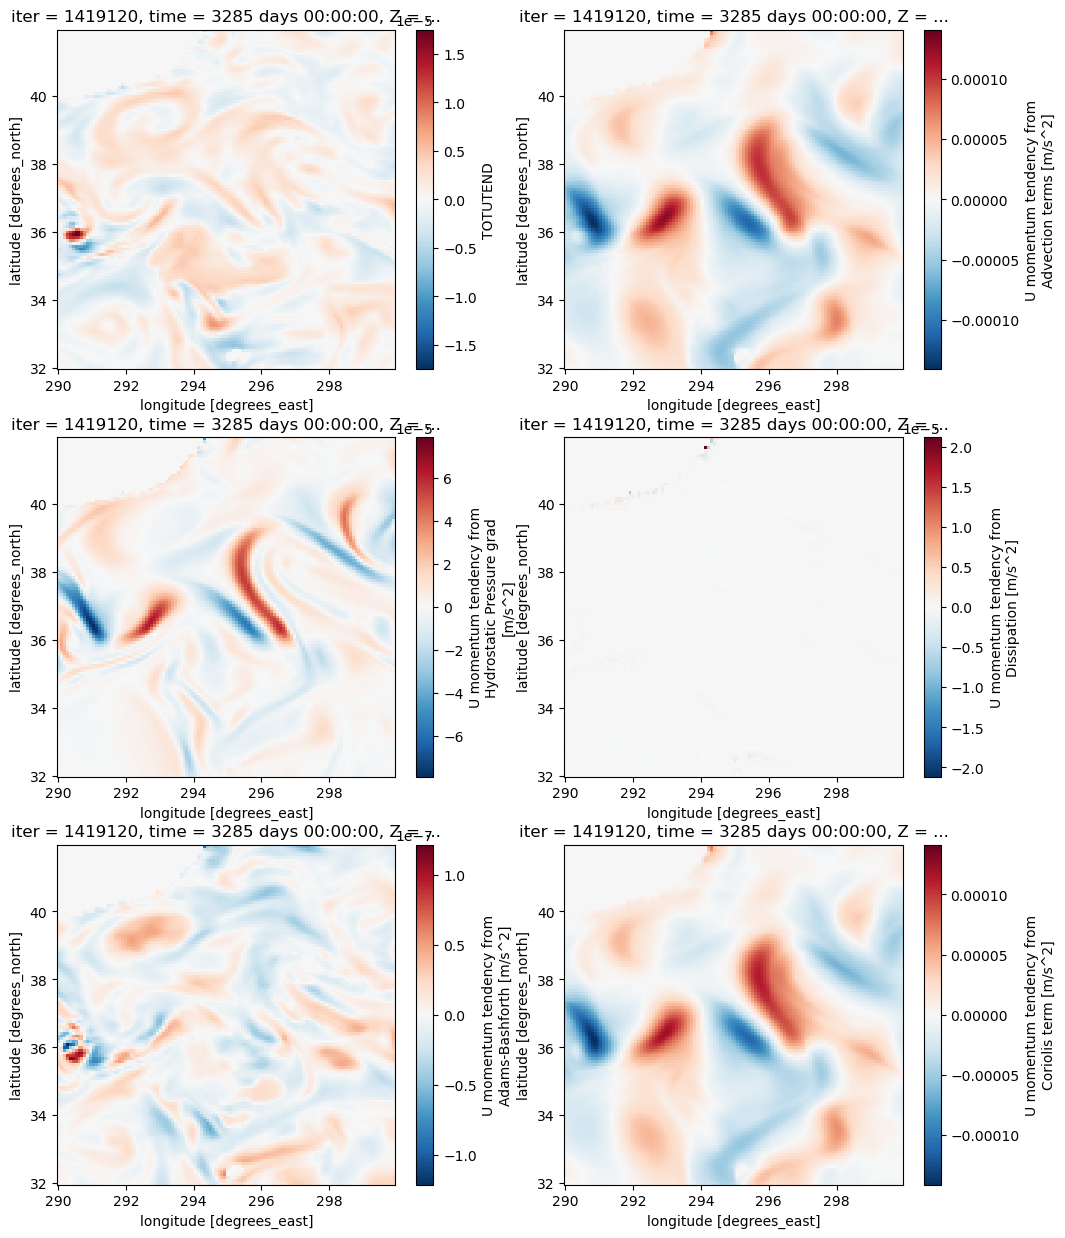

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,15))

(dsg.TOTUTEND/86400.).isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=axes[0,0]) 
dsg.Um_Advec.isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=axes[0,1])

dsg.Um_dPHdx.isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=axes[1,0])
dsg.Um_Diss.isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=axes[1,1])

dsg.AB_gU.isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=axes[2,0])
dsg.Um_Cori.isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=axes[2,1])

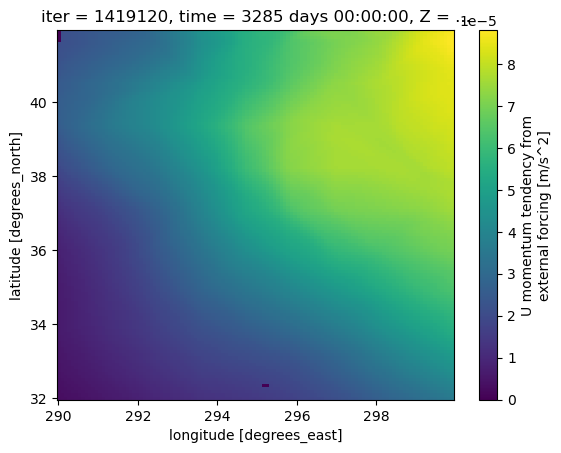

In [20]:
dsg.Um_Ext.isel(Z=0,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot()

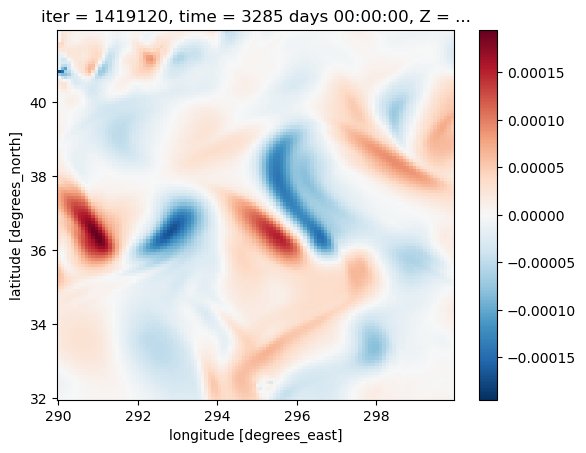

In [21]:
Um_dEdx.isel(Z=0,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot()

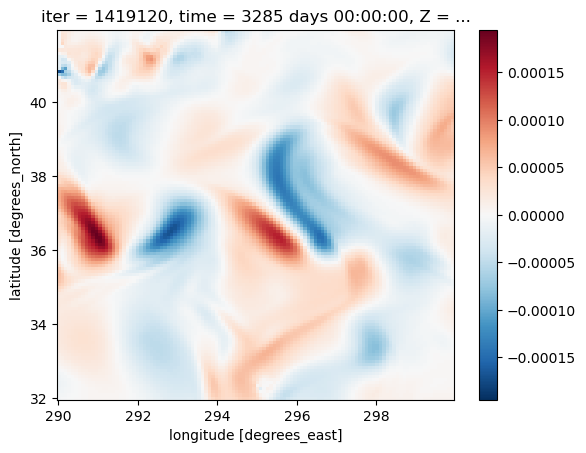

In [24]:
Um_dEdx.isel(Z=1,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot()

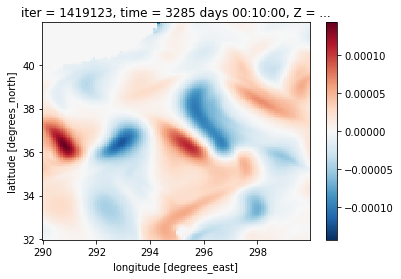

In [39]:
(dsg.Um_dPHdx+Um_dEdx).isel(Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot()

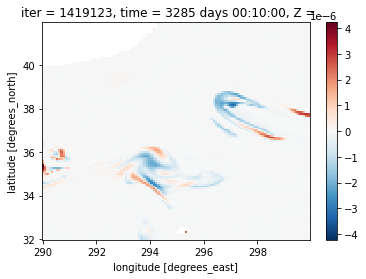

In [109]:
Um_Disv.where(dsreg.maskW!=0.).isel(Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot()

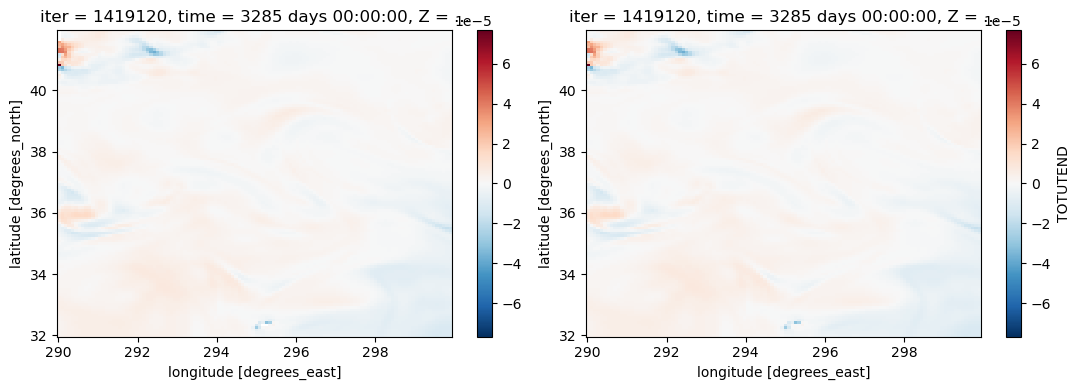

In [12]:
fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
((dsg.Um_Advec 
  # +dsg.Um_Cori
  +dsg.Um_dPHdx
  +Um_dEdx
  +dsg.Um_Diss
  +Um_Disv
  +dsg.Um_Ext
  +dsg.AB_gU
 ).where(dsg.maskW!=0.).isel(Z=0,YC=slice(ng,-ng),XG=slice(ng,-ng)) 
 # + uMetric.isel(Z=0)
).plot(ax=ax1)   
(dsg.TOTUTEND/86400.).isel(Z=0,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=ax2)

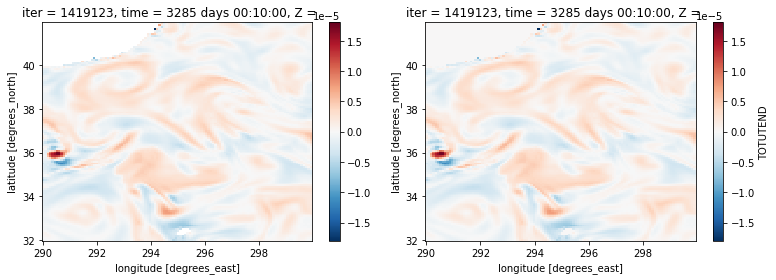

In [12]:
fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
((dsg.Um_Advec 
  # +dsg.Um_Cori
  +dsg.Um_dPHdx
  +Um_dEdx
  +dsg.Um_Diss
  +Um_Disv
  # +dsg.Um_Ext
  +dsg.AB_gU
 ).where(dsg.maskW!=0.).isel(Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)) 
 # + uMetric.isel(Z=0)
).plot(ax=ax1)   
(dsg.TOTUTEND/86400.).isel(Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=ax2)

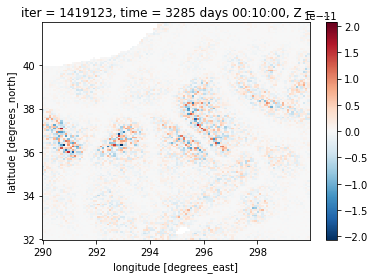

In [102]:
(dsg.TOTUTEND/86400. - (dsg.Um_Advec 
                        # +dsg.Um_Cori
                        +dsg.Um_dPHdx
                        +Um_dEdx
                        +dsg.Um_Diss
                        +Um_Disv
                        # +dsg.Um_Ext
                        +dsg.AB_gU
                       ) 
).where(dsg.maskW!=0.).isel(Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot()

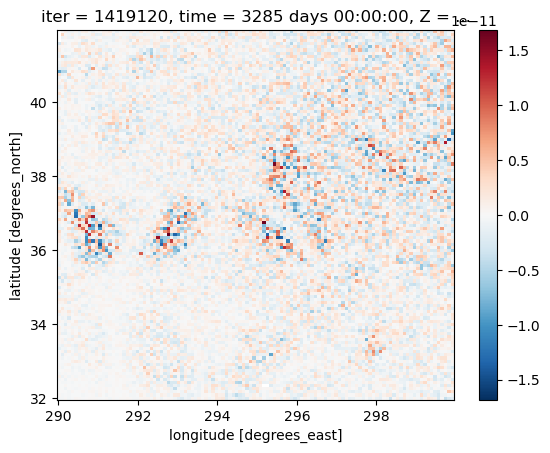

In [13]:
(dsg.TOTUTEND/86400. - (dsg.Um_Advec 
                        # +dsg.Um_Cori
                        +dsg.Um_dPHdx
                        +Um_dEdx
                        +dsg.Um_Diss
                        +Um_Disv
                        +dsg.Um_Ext
                        +dsg.AB_gU
                       ) 
).where(dsg.maskW!=0.).isel(Z=0,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot()

In [14]:
u = dsreg.UVEL.where(ds.maskW!=0.).reset_coords(drop=True).chunk({'Z':4})
v = dsreg.VVEL.where(ds.maskS!=0.).reset_coords(drop=True).chunk({'Z':4})
w = dsreg.WVEL.reset_coords(drop=True).chunk({'Zl':4})
# phi = phi.where(ds.maskC!=0.).reset_coords(drop=True).chunk({'Z':4})

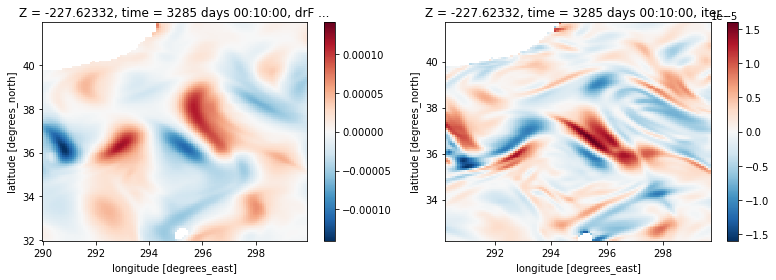

In [16]:
f = gsw.f(ds.YC)
# Omega = 2*np.pi/86400
# f = 2*Omega*np.sin(ds.YC*2*np.pi/360.)
fv_old = f*grid.interp(grid.interp(v,'Y',boundary='extend'),'X',boundary='extend'
                      ).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))
fv_conserv = (grid.interp(f*ds.rA*ds.drF*ds.hFacC*grid.interp(v,'Y',boundary='extend'),'X',boundary='extend')
              / ds.rAw/ds.drF/ds.hFacW
             ).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))

fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
(fv_conserv).isel(time=0,Z=0).plot(ax=ax1)
(fv_conserv.isel(time=0,Z=0)-dsdiag.Um_Cori).where(ds.maskW!=0.).isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=ax2)      

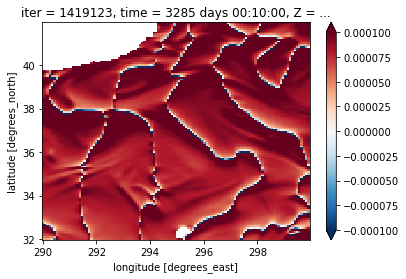

In [18]:
(dsg.Um_Cori/(grid.interp(ds.rA*ds.drF*ds.hFacC*grid.interp(v,'Y',boundary='extend'),'X',boundary='extend')
                          / ds.rAw/ds.drF/ds.hFacW
                         )
).where(ds.maskW!=0.).isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(vmax=1e-4)

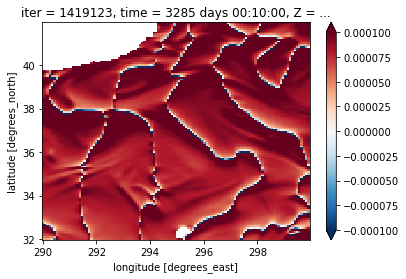

In [19]:
(dsg.Um_Cori/grid.interp(grid.interp(v,'Y',boundary='extend'),'X',boundary='extend'
                        )
).where(ds.maskW!=0.).isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(vmax=1e-4)

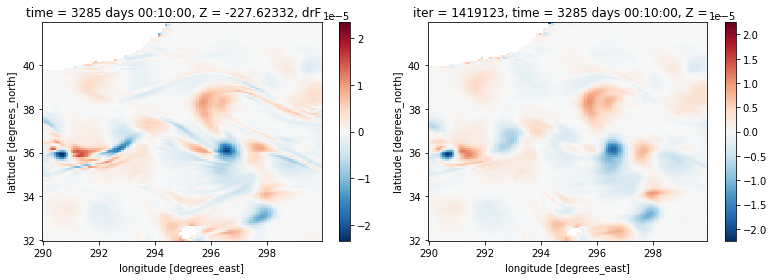

In [34]:
utTrans = u.reset_coords(drop=True) * xA * dsreg.hFacW
vtTrans = v * yA * dsreg.hFacS
rtTrans = grid.interp((w*dsreg.rA).reset_coords(drop=True),'X',boundary='extend')
AuuT = (grid.interp(utTrans,'X',boundary='extend')
        * grid.interp(u,'X',boundary='extend')
)
AvuT = (grid.interp(vtTrans,'X',boundary='extend')
        * grid.interp(u,'Y',boundary='extend')
)
AwuT = (rtTrans
        * grid.interp(u,'Z',boundary='extend')
)

Au = ((grid.diff(AuuT,'X',boundary='extend')
       + grid.diff(AvuT,'Y',boundary='extend')
       - grid.diff(AwuT,'Z',boundary='extend')
      ) / dsreg.drF/dsreg.rAw/dsreg.hFacW).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))

fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
(Au).isel(time=0,Z=0).plot(ax=ax1)
(-(dsg.Um_Advec
   # - fv_conserv.isel(time=0,Z=0)
   - dsg.Um_Cori
   # - Um_dEdx
  ).where(dsreg.maskW!=0.).isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng))
 # - uMetric.isel(time=0,Z=0)
).plot(ax=ax2)

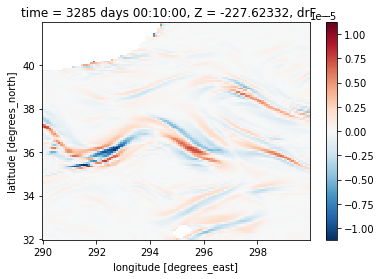

In [32]:
(Au.isel(time=0,Z=0) + (dsg.Um_Advec
                        # - fv_conserv.isel(time=0,Z=0)
                        - dsg.Um_Cori
                        # - Um_dEdx
                       ).where(dsreg.maskW!=0.).isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng))
 # - uMetric.isel(time=0,Z=0)
).plot()

Text(0.5, 1.0, 'Metric')

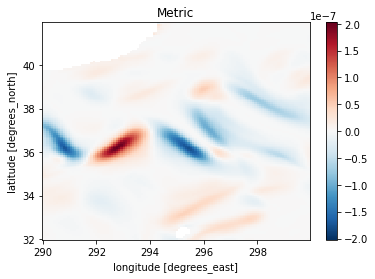

In [22]:
rSphere = 6.37e6
tanPhiAtU = np.tan(ds.YC*np.pi/180.)
uMetric = (
         u*rSphere**-1
         *( grid.interp(grid.interp(v,'X',boundary='extend'),'Y',boundary='extend')
          )*tanPhiAtU
).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))

fig, ax = plt.subplots()
uMetric.isel(time=0,Z=0).plot(ax=ax)
ax.set_title(r"Metric")

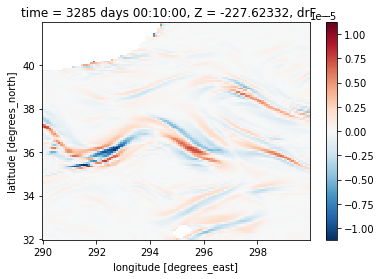

In [82]:
(Au.isel(time=0,Z=0) + (dsdiag.Um_Advec
   # - fv_conserv.isel(time=0,Z=0)
                        - dsdiag.Um_Cori
   # - Um_dEdx
                       ).where(ds.maskW!=0.).isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng))
 # - uMetric.isel(time=0,Z=0)
).plot()

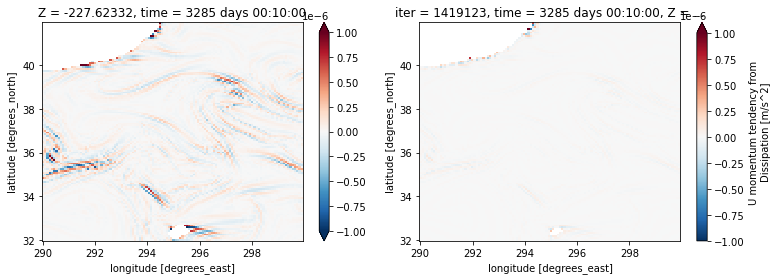

In [35]:
cosFacU = np.cos(dsreg.YC*2*np.pi/360.)
cosFacV = np.cos(dsreg.YG*2*np.pi/360.)
        
fZon = (dsreg.drF*dsreg.hFacC
        *grid.interp(dsreg.dyG,'X',boundary='extend')
        *grid.interp(dsreg.dxG,'Y',boundary='extend')**-1
        *grid.diff(u,'X',boundary='extend')
)
        
fMer = (dsreg.drF*grid.interp(dsreg.hFacW,'Y',boundary='extend')
        *grid.interp(dsreg.dxG,'X',boundary='extend')
        *grid.interp(dsreg.dyG,'Y',boundary='extend')**-1
        *grid.diff(u,'Y',boundary='extend')
)
        
del2u = (dsreg.drF**-1*dsreg.hFacW**-1
         *dsreg.rAw**-1
         *( grid.diff(fZon,'X',boundary='extend')
           +grid.diff(fMer,'Y',boundary='extend')
          )
).where(dsreg.maskW!=0.)

xViscFluxU = (grid.interp(dsreg.dyG,'X',boundary='fill')*dsreg.drF*dsreg.hFacC
          *(
            -Kh*grid.diff(u,'X',boundary='extend')
            *cosFacU
            +K4*grid.diff(del2u,'X',boundary='extend')
            *cosFacU
           )*grid.interp(dsreg.dxG,'Y',boundary='extend')**-1
)
        
yViscFluxU = (grid.interp(dsreg.dxG,'X',boundary='extend')
              *dsreg.drF*grid.interp(dsreg.hFacW,'Y',boundary='extend')
          *(
            -Kh*grid.diff(u,'Y',boundary='extend')
            # *cosFacV
            +K4*grid.diff(del2u,'Y',boundary='extend')
            # *cosFacV
           )*grid.interp(dsreg.dyG,'Y',boundary='extend')**-1
)
#################################       
        
Du_h = -(( grid.diff(xViscFluxU,'X',boundary='extend') 
          +grid.diff(yViscFluxU,'Y',boundary='extend') 
) / dsreg.rAw/dsreg.drF/dsreg.hFacW).reset_coords(drop=True)

Du_v = (grid.diff(grid.diff(u,'Z',boundary='extend',to='outer')
                            / dsreg.drC*dsreg.rAw,
                  'Z',boundary='extend'
                 ) / dsreg.drF/dsreg.rAw
).reset_coords(drop=True) * Kr

Du = (Du_h + Du_v).isel(Z=[14,24],YC=slice(ng,-ng),XG=slice(ng,-ng))

fig, (ax1,ax2) = plt.subplots(figsize=(11,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
Du.isel(time=0,Z=0).plot(ax=ax1,vmax=1e-6)
(dsg.Um_Diss).where(ds.maskW!=0.).isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng)).plot(ax=ax2,vmax=1e-6)      

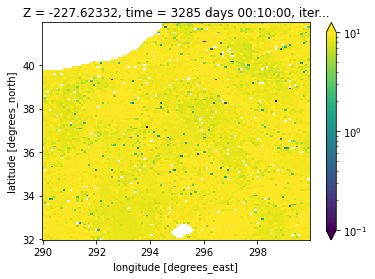

In [36]:
(Du.isel(time=0,Z=0) / dsg.Um_Diss.where(ds.maskW!=0.).isel(time=0,Z=14,YC=slice(ng,-ng),XG=slice(ng,-ng))
).plot(vmax=1e1, vmin=1e-1, norm=clr.LogNorm())

In [10]:
reg = 0
ng = 3

ds = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                     grid_dir=gdir,
                     prefix=['snap_diagOcn'], delta_t=2e2,
                     iters=1419120, 
                    )
dsg = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['diagUm'], delta_t=2e2,
                      iters=1419120, ignore_unknown_vars=True
                     )
Um_dEdx = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run1967/ocn/diagUm'), 
                                          itrs=1419120, rec=3,    # U from surface pressure
                         # usememmap=True
                                     ),
                          dims=ds.UVEL.isel(time=0).dims, coords=ds.UVEL.isel(time=0).coords
                         )   
Um_Disv = xr.DataArray(mitutils.rdmds(op.join(ddir,'ensm/run1967/ocn/diagUm'), 
                                          itrs=1419120, rec=5,    # Vertical dissipation
                         # usememmap=True
                                     ),
                          dims=ds.UVEL.isel(time=0).dims, coords=ds.UVEL.isel(time=0).coords
                         )   

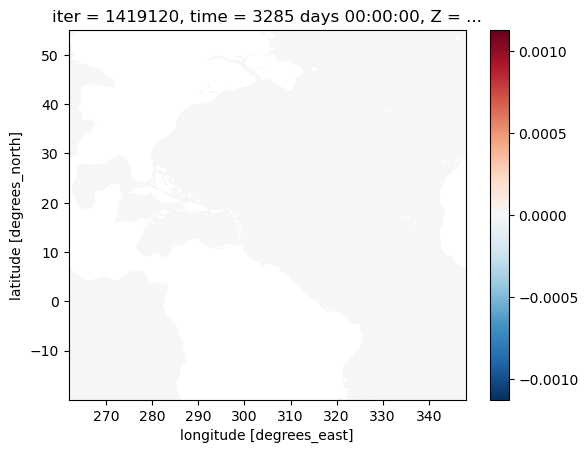

In [12]:
(dsg.TOTUTEND/86400. - (dsg.Um_Advec 
                        # +dsg.Um_Cori
                        +dsg.Um_dPHdx
                        +Um_dEdx
                        +dsg.Um_Diss
                        +Um_Disv
                        # +dsg.Um_Ext
                        +dsg.AB_gU
                       ) 
).where(dsg.maskW!=0.).isel(Z=14,
                            # YC=slice(ng,-ng),XG=slice(ng,-ng)
                           ).plot()